[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/feiglab/mc-trpcys/blob/main/mc-trpcys.ipynb)

# Trp-Cys quenching curves via Monte Carlo sampling of 1D potentials

Quenching of the tryptophan triplet state by cysteine is an experimental probe for characterizing intra- and intermolecular dynamics in proteins. The method is sensitive to distances up to about 1 nm and time scales between 100 ns and 50  $\mu$s.

In this notebook, 1D potentials are used to model Trp-Cys distance distributions. After sampling via Monte Carlo simulation with fixed or variable step sizes, quenching curves are calculated that can be compared to experimental data.

This approach is described in more detail here:

**Characterizing Transient Protein-Protein Interactions by Trp-Cys Quenching and Computer Simulations**<BR>
Lim Heo, Katukurunde Gamage, Gilberto Valdes-Garcia, Lisa J. Lapidus, Michael Feig<BR>
To be published (2022)

The potential that is being considered has the following function form:

$$
\Large V(r) = \epsilon \left(\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right) + a e^{\frac{-(r-\mu)^2}{w}}+\frac{d k}{r}e^{\frac{-r}{k}}
$$

In [1]:
import math as m

def efunc(r,sig=3.28,eps=7.0,a=0.6,mu=4.74,w=0.15,d=0.0,k=10.0):
    val=eps*((sig/r)**12-(sig/r)**6)+a*m.exp(-(r-mu)**2/w)+d*k/r*m.exp(-r/k)
    return val

Let's check what the potential looks like:

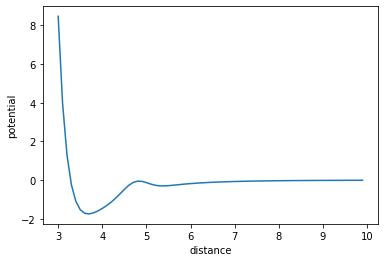

In [2]:
import numpy as np
import matplotlib.pyplot as plt

distance=np.arange(3.0,10.0,0.1)
potential=np.array(list(map(efunc,distance)))

plt.plot(distance,potential)
plt.xlabel('distance')
plt.ylabel('potential')
plt.show()

For sampling we will use a slightly modified function that implements a finite box size, allows the step rise of the function at short distances to have a different value of $\epsilon$, and turns on the long-range Debye-Hückel potential only after a certain distance.

In [3]:
def energy(r,box=25.0,sig=3.28,eps=7.0,epsl=-1,a=0.6,mu=4.74,w=0.15,d=0.0,k=10.0,dhcut=10.0):
    if epsl<0:
        epsl=eps
        
    x=r
    if (x>box):
        x=box-(x-box)
    if (x<=0.0):
        x=0.01
    
    minval=(2.0**(1.0/6.0))*sig
    
    if (dhcut<=0.01):
        if (x>minval):
            return efunc(x,sig=sig,eps=eps,a=a,mu=mu,w=w,d=d,k=k)
        else:
            pl=efunc(minval,sig=sig,eps=epsl,a=0.0,d=0.0)
            pr=efunc(minval,sig=sig,eps=eps,a=a,mu=mu,w=w,d=d,k=k)
            return efunc(x,sig=sig,eps=epsl,a=0.0,d=0.0)-pl+pr
    else:
        if (x<dhcut):
            if (x>minval):
                return efunc(x,sig=sig,eps=eps,a=a,mu=mu,w=w,d=0.0)
            else:
                pl=efunc(minval,sig=sig,eps=epsl,a=0.0,d=0.0)
                pr=efunc(minval,sig=sig,eps=eps,a=a,mu=mu,w=w,d=0.0)
                return efunc(x,sig=sig,eps=epsl,a=0.0,d=0.0)-pl+pr
        else:
            pl=efunc(dhcut,sig=sig,eps=eps,a=a,mu=mu,w=w,d=0.0)
            pr=efunc(dhcut,sig=sig,eps=eps,a=a,mu=mu,w=w,d=d,k=k)
            return efunc(x,sig=sig,eps=eps,a=a,mu=mu,w=w,d=d,k=k)-pr+pl  
  


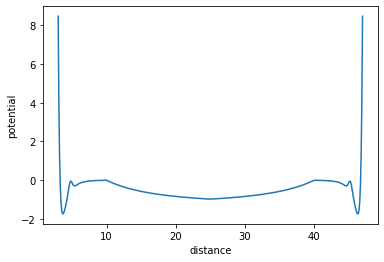

In [4]:
distance=np.arange(3.0,47.1,0.1)
potential=np.array(list(map(lambda p: energy(p,box=25.0, d=1.0,k=20.0),distance)))

plt.plot(distance,potential)
plt.xlabel('distance')
plt.ylabel('potential')
plt.show()

The following code samples the potential via Monte Carlo

In [5]:
import random 

def mcsample(nsteps,box=25.0,rinit=-1,dr=5.0,v1=0.0,kt=1.0):
    if (rinit<0):
        r=box/2.0
    else:
        r=rinit
        
    data=np.zeros(nsteps)
    
    for i in range(nsteps):
        tr=r
        if (tr>box):
            tr=box-(tr-box)
        
        tdr=dr+v1*tr
        step=tdr*random.random()
        if (random.random()<0.5):
            stepdir=1.0
        else:
            stepdir=-1.0
        
        newr=r+step*stepdir
        
        current_e=energy(r,box=box,d=1.0,k=20.0)
        new_e=energy(newr,box=box)
        delta_e=new_e-current_e
        if (delta_e<0):
            r=newr
        else:
            if(random.random()<m.exp(-delta_e/kt)):
                r=newr

        data[i]=r
    
    return data

In [6]:
nsteps=20000
sample=mcsample(nsteps,box=25.0)

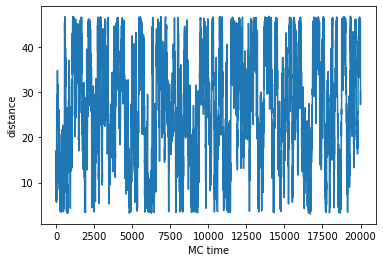

In [7]:
time=np.arange(min(nsteps,20000))

plt.plot(time,sample[0:min(nsteps,20000)])
plt.xlabel('MC time')
plt.ylabel('distance')
plt.show()

Let's generate a probability distribution function from the distance histogram:

In [8]:
def histogram(data,res=0.1):
    nhist=int(max(data)/res+1.5)
    hist=np.zeros(nhist)
    for n in data:
        inx=int(n/res+0.5)
        hist[inx]+=1   
    maxval=0
    for h in hist:
        if h>maxval:
            maxval=h
    outdata=np.zeros([3,nhist])
    for n in range(nhist):
        outdata[0,n]=n*res
        outdata[1,n]=hist[n]
        if (hist[n]>0):
            outdata[2,n]=-m.log(hist[n]/maxval)
        else:
            outdata[2,n]=9999.0;
    return outdata

In [9]:
hist=histogram(sample)

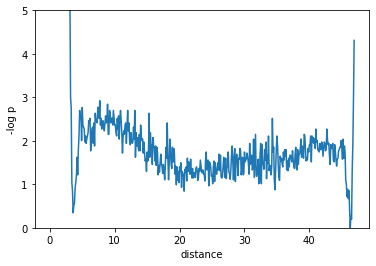

In [10]:
plt.plot(hist[0],hist[2])
plt.xlabel('distance')
plt.ylabel('-log p')
plt.ylim(0,5)
plt.show()

We can now calculate a quenching function from the sampled data according to:

$$
\Large S_{quenching}(t)=\left< exp\left(-\int_{0}^{t}q(t')dt'\right)\right>
$$

from the quenching function

$$
\Large q(r) = k_0 exp\left(-\beta(r-a)\right)
$$

Typical parameter values are:

$$
\Large k_0 = 4.2 x 10^9 s^{-1}; a = 3.5 Å; \beta = 4/Å
$$


In [11]:
def quench(data,box=25.0,q0=4.2,a0=3.5,beta=4.0):
    n=len(data)
    tarr=np.zeros(n)
    xarr=np.zeros(n)
    exarr=np.zeros(n)
    for i in range(n):
        tarr[i]=i
        x=data[i]
        if (x>box):
            x=box-(x-box)
        xarr[i]=x
        exarr[i]=q0*m.exp(-beta*(x-a0))
    
    tmax=n
    acc=np.zeros(tmax)
    nacc=np.zeros(tmax)
    for i in range(n-1):
        sum=exarr[i]
        for j in range(i+1,n):
            sum+=exarr[j]
            dt=j-i
            acc[dt]+=m.exp(-sum)
            nacc[dt]+=1
    
    outdata=np.zeros([3,tmax])
    outdata[0,0]=0
    outdata[1,0]=1
    outdata[2,0]=0
    for i in range(1,tmax):
        outdata[0,i]=i
        outdata[2,i]=nacc[i]
        if (nacc[i]>0):
            outdata[1,i]=acc[i]/nacc[i]
        else:
            outdata[1,i]=0.0;
            
            
    return outdata

In [12]:
q=quench(sample,box=25.0)

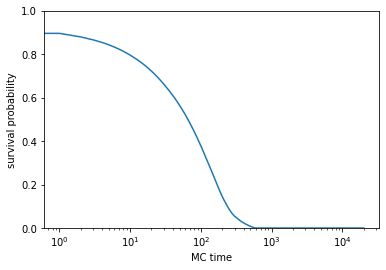

In [13]:
plt.plot(q[0],q[1])
plt.xlabel('MC time')
plt.ylabel('survival probability')
plt.ylim(0,1)
plt.xscale("log")
plt.show()

Finally we calculate the derivative dA/dlog(t)

In [14]:
def linearfit(xdata,ydata):
    mval=nval=0.0
    sx=sy=0.0

    nn=min(len(xdata),len(ydata))
    
    for i in range(nn):
        sx+=xdata[i]
        sy+=ydata[i]
    ss=nn
    sxoss=sx/ss
    
    st2=0.0
    
    for i in range(nn):
        t=xdata[i]-sxoss
        st2+=t*t
        mval+=t*ydata[i]
        
    mval/=st2
    nval=(sy-sx*mval)/ss

    siga=m.sqrt((1.0+sx*sx/(ss*st2))/ss)
    sigb=m.sqrt(1.0/st2)

    chi2=vary=0.0
    for i in range(nn):
        tc=(ydata[i]-nval-mval*xdata[i])
        chi2+=tc*tc
        tc=(ydata[i]-sy/ss)
        vary+=tc*tc

    cval=1.0
    if (vary>0 or vary<0):
        sv=1.0-(chi2/vary)
        if (sv>=0):
            cval=m.sqrt(sv);
            
    if (mval<0.0):
        cval=-cval

    return(mval,nval,cval)

def qderiv(data,winsize=3):
    n=len(data[0])
    ddata=np.zeros([4,n])
    for i in range(n):
        ddata[0,i]=data[0,i]
        ddata[1,i]=data[1,i]
        ddata[3,i]=data[2,i]
        xdata=np.zeros(winsize*2+1)
        ydata=np.zeros(winsize*2+1)
        ndat=0
        for j in range(i-winsize,i+winsize,1):
            if (j>0 and j<n):
                xdata[ndat]=m.log10(data[0,j])
                ydata[ndat]=data[1,j]
                ndat+=1
        (mval,nval,cval)=linearfit(xdata[0:ndat],ydata[0:ndat])
        ddata[2,i]=mval
    return ddata

In [15]:
dq=qderiv(q)

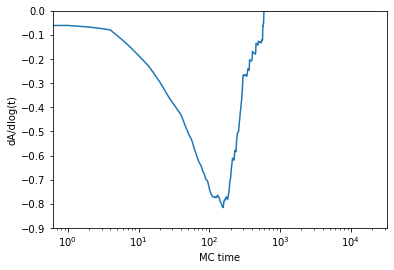

In [18]:
plt.plot(dq[0],dq[2])
plt.xlabel('MC time')
plt.ylabel('dA/dlog(t)')
plt.ylim(-0.9,0)
plt.xscale("log")
plt.show()